# Описание задания

**Цель домашнего задания:** решение комплексной задачи машинного обучения.

## Задание

1. Поиск и выбор набора данных для построения моделей машинного обучения. На основе выбранного набора данных студент должен построить модели машинного обучения для решения или задачи классификации, или задачи регрессии.
2. Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.
3. Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.
4. Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения. В зависимости от набора данных, порядок выполнения пунктов 2, 3, 4 может быть изменен.
5. Выбор метрик для последующей оценки качества моделей. Необходимо выбрать не менее двух метрик и обосновать выбор.
6. Выбор наиболее подходящих моделей для решения задачи классификации или регрессии. Необходимо использовать не менее трех моделей, хотя бы одна из которых должна быть ансамблевой.
7. Формирование обучающей и тестовой выборок на основе исходного набора данных.
8. Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.
9. Подбор гиперпараметров для выбранных моделей. Рекомендуется подбирать не более 1-2 гиперпараметров. Рекомендуется использовать методы кросс-валидации. В зависимости от используемой библиотеки можно применять функцию GridSearchCV, использовать перебор параметров в цикле, или использовать другие методы.
10. Повторение пункта 8 для найденных оптимальных значений гиперпараметров. Сравнение качества полученных моделей с качеством baseline-моделей.
11. Формирование выводов о качестве построенных моделей на основе выбранных метрик.

# Ход выполнения домашнего задания

## Выбор датасета
​
​
В качестве исходных данных для решения поставленной задачи был выбран датасет Heart Disease UCI (https://www.kaggle.com/ronitf/heart-disease-uci). 303 записи, 14 признаков, целевой признак относится к наличию болезни сердца у пациента: 0 - нет болезни сердца, 1 - есть. На основе данного датасета будем производить построение модели для решения задачи классификации.

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from google.colab import files
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
os.listdir()
data = pd.read_csv('drive/My Drive/mmo_datasets/heart.csv',
                   sep=",", encoding="iso-8859-1")

## Разведочный анализ данных

In [0]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [0]:
data.shape

(303, 14)

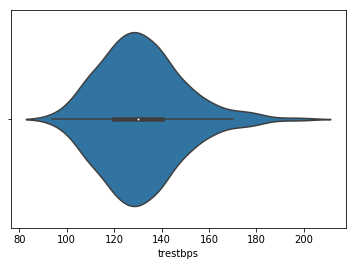

In [0]:
sns.violinplot(x=data['trestbps'])

In [0]:
total_count = data.shape[0]
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0:
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'
              .format(col, dt, temp_null_count, temp_perc))

data_cleared = data

Пропусков в данных обнаружено не было.

In [0]:
data.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

В модели отсутствуют категориальные признаки, поэтому нет необходимости проводить кодирование. В качетсве признака для классификации выберем предлагаемый признак target - наличие у пациента сердечных заболеваний.

## Проведение корреляционного анализа данных

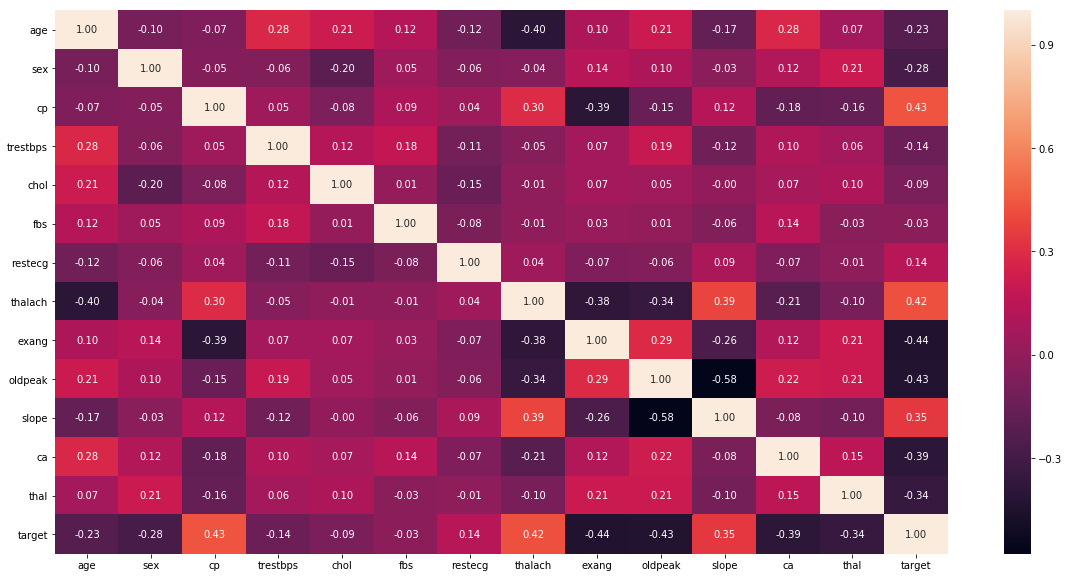

In [0]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(data.corr(), annot=True, fmt='.2f', ax=ax)

В результате построения корреляционной матрицы было выявлено, что признаки fbs (fasting blood sugar - уровень сахара в крови натощак) и chol (сыворотка холесторальная) слабо коррелируют с целевым признаком (0.03 и 0.09 соответственно), ввиду чего уберем данные признак из рассмотрения, чтобы предотвратить возможное ухудшение параметров работы моделей.

In [0]:
data = data.drop(['fbs', 'chol'], axis=1)

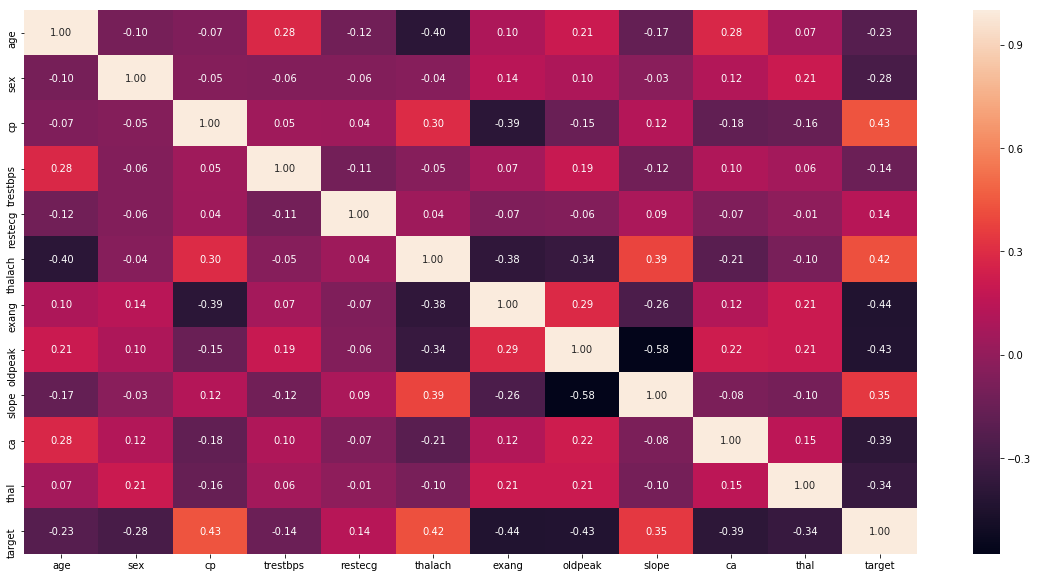

In [0]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(data.corr(), annot=True, fmt='.2f', ax=ax)

## Выбор метрик для оценки качества моделей

**balanced_accuracy_score** - сбалансированная точность в задачах двоичной и мультиклассовой классификации для решения проблемы несбалансированных наборов данных. 

**precision_score** - доля верно предсказанных классификатором положительных объектов, из всех объектов, которые классификатор верно или неверно определил как положительные.

**recall_score** - доля верно предсказанных классификатором положительных объектов, из всех действительно положительных объектов. 

**f1_score** - объединяет precision и recall в единую метрику
$$
    F_1 = 2* \frac{precision*recall}{precision+recall}
$$

In [0]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

## Выбор моделей для решения задачи классификации

**SGDClassifier** - стохастический градиентный спуск.

**DecisionTreeClassifier** - дерево решений.

**RandomForestClassifier** - случайный лес.

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Разделение выборки на обучающую и тестовую

In [0]:
target = data_cleared['target']
data_cleared = data_cleared.drop('target', axis=1)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    data_cleared, 
    target, 
    test_size=0.2, 
    random_state=1
)

In [0]:
X_train.shape, Y_train.shape

((242, 13), (242,))

In [0]:
X_test.shape, Y_test.shape

((61, 13), (61,))

## Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров

In [0]:
sgd = SGDClassifier().fit(X_train, Y_train)
predicted_sgd = sgd.predict(X_test)

In [0]:
def print_accuracy_metrics(Y_test, predicted_sgd): 
  print("balanced_accuracy_score {}".format(
      balanced_accuracy_score(Y_test, predicted_sgd)))
  print("precision_score {}".format(
      precision_score(Y_test, predicted_sgd, average='weighted')))
  print("recall_score {}".format(
      recall_score(Y_test, predicted_sgd, average='weighted')))
  print("f1_score {}".format(
      f1_score(Y_test, predicted_sgd, average='weighted')))

In [0]:
print_accuracy_metrics(Y_test, predicted_sgd)

balanced_accuracy_score 0.55
precision_score 0.7634256642170718
recall_score 0.5573770491803278
f1_score 0.4434434602052948


In [0]:
dt = DecisionTreeClassifier().fit(X_train, Y_train)
predicted_dt = dt.predict(X_test)

In [0]:
print_accuracy_metrics(Y_test, predicted_dt)

balanced_accuracy_score 0.7543010752688173
precision_score 0.7545037898818968
recall_score 0.7540983606557377
f1_score 0.7540983606557377


In [0]:
rfc = RandomForestClassifier().fit(X_train, Y_train)
predicted_rfc = rfc.predict(X_test)

In [0]:
print_accuracy_metrics(Y_test, predicted_rfc)

balanced_accuracy_score 0.7043010752688172
precision_score 0.7054857710595417
recall_score 0.7049180327868853
f1_score 0.7044410684002261


## Подбор гиперпараметров для выбранных моделей

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
n_range = np.array(range(0,100,5))
n_range = n_range / 100
tuned_parameters = [{'l1_ratio': n_range}]
tuned_parameters

[{'l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
         0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])}]

In [0]:
clf_gs_sgd = GridSearchCV(SGDClassifier(), tuned_parameters, cv=5,
                      scoring='accuracy')
clf_gs_sgd.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])}],
             pre_dispat

In [0]:
clf_gs_sgd.best_params_

{'l1_ratio': 0.75}

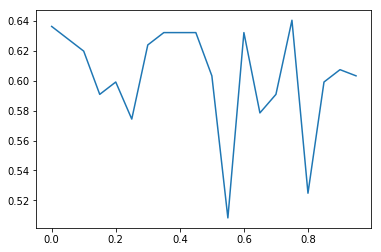

In [0]:
plt.plot(n_range, clf_gs_sgd.cv_results_['mean_test_score'])

In [0]:
n_range = np.array(range(1,7,1))
tuned_parameters = [{'max_depth': n_range}]
tuned_parameters

[{'max_depth': array([1, 2, 3, 4, 5, 6])}]

In [0]:
clf_gs_dt = GridSearchCV(DecisionTreeClassifier(random_state=1), tuned_parameters,
                          cv=5, scoring='accuracy')
clf_gs_dt.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=1,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid=[{'max_depth': array([1, 2, 3, 4, 5, 6])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Fa

In [0]:
clf_gs_dt.best_params_

{'max_depth': 4}

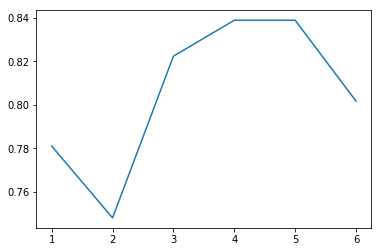

In [0]:
plt.plot(n_range, clf_gs_dt.cv_results_['mean_test_score'])

In [0]:
rfc_n_range = np.array(range(5,100,5))
rfc_tuned_parameters = [{'n_estimators': rfc_n_range}]
rfc_tuned_parameters

[{'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
         90, 95])}]

In [0]:
gs_rfc = GridSearchCV(RandomForestClassifier(), rfc_tuned_parameters, cv=5,
                      scoring='accuracy')
gs_rfc.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [0]:
gs_rfc.best_params_

{'n_estimators': 15}

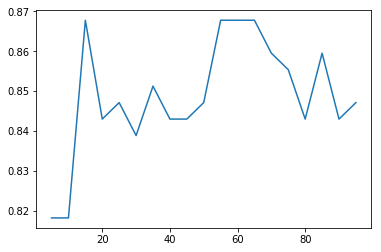

In [0]:
plt.plot(rfc_n_range, gs_rfc.cv_results_['mean_test_score'])

## Оценка качества работы моделей с подобранными гиперпараметрами

In [0]:
import warnings
warnings.filterwarnings('ignore')

sgd_optimized = SGDClassifier(l1_ratio=clf_gs_sgd.best_params_['l1_ratio']).fit(X_train, Y_train)
predicted_sgd_opt = sgd_optimized.predict(X_test)

In [0]:
print_accuracy_metrics(Y_test, predicted_sgd)
print()
print_accuracy_metrics(Y_test, predicted_sgd_opt)

balanced_accuracy_score 0.55
precision_score 0.7634256642170718
recall_score 0.5573770491803278
f1_score 0.4434434602052948

balanced_accuracy_score 0.6430107526881721
precision_score 0.6792320504953099
recall_score 0.639344262295082
f1_score 0.6208647171761926


In [0]:
dt_optimized = DecisionTreeClassifier(max_depth=clf_gs_dt.best_params_['max_depth']).fit(X_train, Y_train)
predicted_dt_opt = dt_optimized.predict(X_test)

In [0]:
print_accuracy_metrics(Y_test, predicted_dt)
print()
print_accuracy_metrics(Y_test, predicted_dt_opt)

balanced_accuracy_score 0.7543010752688173
precision_score 0.7545037898818968
recall_score 0.7540983606557377
f1_score 0.7540983606557377

balanced_accuracy_score 0.7870967741935484
precision_score 0.7873083024854575
recall_score 0.7868852459016393
f1_score 0.7868852459016393


In [0]:
rfc_optimized = RandomForestClassifier(n_estimators=gs_rfc.best_params_['n_estimators']).fit(X_train, Y_train)
predicted_rfc_opt = rfc_optimized.predict(X_test)

In [0]:
print_accuracy_metrics(Y_test, predicted_rfc)
print()
print_accuracy_metrics(Y_test, predicted_rfc_opt)

balanced_accuracy_score 0.7043010752688172
precision_score 0.7054857710595417
recall_score 0.7049180327868853
f1_score 0.7044410684002261

balanced_accuracy_score 0.7365591397849462
precision_score 0.7413078724554134
recall_score 0.7377049180327869
f1_score 0.7362855723511461


## Выводы

Подбор гиперпараметров для выбранных моделей машинного обучения позволил увеличить точность решения задачи классификации на обучаемых моделях. Наибольший прирост в точности получила модель стохастического градиентного спуска. Однако наиболее точно с задачей классификации на данном датасете справляется дерево решений, как до подбора гиперпараметров, так и после.

## Список литературы


1. Heart Disease UCI: https://www.kaggle.com/ronitf/heart-disease-uci
2. Model evaluation: quantifying the quality of predictions: https://scikit-learn.org/stable/modules/model_evaluation.html
3. Model selection: choosing estimators and their parameters: https://scikit-learn.org/
stable/tutorial/statistical_inference/model_selection.html
4. SGDClassifier: https://scikit-learn.org/stable/modules/generated/
sklearn.linear_model.SGDClassifier.html
5. DecisionTreeClassifier: https://scikit-learn.org/stable/modules/generated/
sklearn.tree.DecisionTreeClassifier.html
6. RandomForestClassifier: https://scikit-learn.org/stable/modules/generated/
sklearn.ensemble.RandomForestClassifier.html